# Homework Week 10
Nicola Zomer <br>
08 February, 2023

## Assignment
Simulate the stochastic dynamics of the two stage model using the Gillespie algorithm. 

# Two-stage model for gene expression 
Assuming the cell is a well-stirred chemical reactor, in the language of reaction kinetics we have the following elementary reactions:
$$
\begin{align*}
    \emptyset \quad &\xrightarrow{\nu_0} \quad \text{mRNA} \\
    \text{mRNA} \quad &\xrightarrow{d_0} \quad \emptyset \\
    \text{mRNA} \quad &\xrightarrow{\nu_1} \quad \text{mRNA} + \text{Protein} \\
    \text{Protein} \quad &\xrightarrow{d_1} \quad \emptyset
\end{align*}
$$

The first reaction is a zeroth-order reaction, while the others are first-order (linear and non-autocatalitic reactions). Rate constants ($\nu_0, d_0, \nu_1, d_1$) depend on many factors, but we assume they do not vary in time. This implies that we are modelling intrinsic fluctuations only and neglecting environmental/extrinsic noise. 

Between the experimental data we have, it is worth it to mention that gene expression is intrinsically stochastic. This is because the number of molecules is small and the timing of individual chemical reactions is random. 

However, the **one-stage model** produces no fluctuations at all and describes average values only. To include fluctuations and describe the experimental phenomena we have, a fully stochastic description is needed. This is why we introduce the **two-stage model**, which considers both mRNAs and proteins. This is motivated by the fact that the presence of mRNA is crucial for the production of proteins and cannot be neglected, so that they cannot be disentangled.

The 2 stages of the model, *transcription* and *translation*, are described in the following figure:

![Two Stage Model](images/hw10_two_stage_model.png)

where the rates that describe the model of gene expression are:
- $T_1(m+1, n | m, n) \quad = \quad \nu_0$   

- $T_2(m, n+1 | m, n) \quad = \quad m \nu_1$ 

- $T_3(m-1, n | m, n) \quad = \quad m d_0$   

- $T_4(m, n-1 | m, n) \quad = \quad n d_1$ 

They, respectively, describe transcription, translation, mRNA degradation and protein degradation. Finally, these rates allow us to write the Master Equation of the two-stage model:
$$
\begin{align*}
\dfrac{\partial P_{m,n}(t)}{\partial t} = & \nu_0 \bigg[ P_{m-1,n}(t) - P_{m,n}(t) \bigg] + \nu_1 m \bigg[P_{m,n-1}(t) - P_{m,n}(t) \bigg] + \\
& + d_0 \bigg[(m+1) P_{m+1,n}(t) - m P_{m,n}(t) \bigg] + d_1 \bigg[(n+1) P_{m,n+1}(t) - n P_{m,n}(t) \bigg]
\end{align*}
$$

We simulate it via the **Gillespie algorithm**.





# Gillespie algorithm
The Gillespie algorithm was build to obtain a stochastic simulation of chemical kinetics (see [Gillespie07]). However, it is applied in many different contexts (e.g. ecology and sociology) and it constitutes a powerful tool for simulating complex stochastic dynamics. The algorithm works by specifying a set of possible reaction events, along with their associated rates, and then using probability to determine which reaction will occur next and when. Its strong efficiency comes, indeed, from the fact that it directly provides the time and nature of the next reaction event. 

The algorithm can be summarized by the following steps:
1. Initialize the system state $x(0) = x(t=0)$
2. Calculate the propensity function $a_j(x) \, \forall j$ reaction events, i.e. the rate of each reaction event
3. Compute the total propensity $a_0(x) = \sum_{j=1}^{n} a_j(x)$
4. Compute the occurrence time $\tau$ of the next reaction, sampling it form an exponential distribution with parameter $a_0(x)$:
    $$
        P(\tau|x(t)) = \gamma e^{-\gamma\tau} \quad, \quad \gamma=a_0(x(t))
    $$
5. Determine which is the next reaction by extracting a uniform number $u$ from $\mathcal{U}[0, 1]$. The index $i\in\{1, \dots, n\}$ of such reaction is the smallest index such that $\sum_{j=1}^i a_j(x) \geq u a_0(x)$.
6. Update the state of the system $x(t+\tau)$ by appling the reaction $a_i(x)$; update the time $t$
7. Reiterate from step 2 to 6 until the total time is reached

By construction we are guaranteed that $x(t)$ satisfies the corresponding M.E. as $P(x(t))$ is a solution of it. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def evolve_gillespie(m, n, t, const_rates):
    v0, v1, d0, d1 = const_rates
    
    # step 2: propensity function
    a1 = v0 
    a2 = v1 * m
    a3 = d0 * m
    a4 = d1 * n

    rates = [a1, a2, a3, a4]

    # step 3: total rate
    a0 = sum(rates)

    # step 4: time of the next reaction
    tau = np.random.exponential(1./a0)

    # step 5: determine the index of the next reaction
    u = np.random.rand()

    reaction_idx = np.argmax(np.cumsum(rates) > u*a0)
    
    # step 6: update system state and time
    if reaction_idx == 0:
        m = m + 1
    elif reaction_idx == 1:
        n = n + 1
    elif reaction_idx == 2:
        m = m - 1
    elif reaction_idx == 3:
        n = n - 1
        
    t = t + tau

    return [m, n, t]

In [35]:
# parameters
t_tot = 1e5 

# rates
v0 = 0.8
v1 = 0.25
d0 = 0.08 
d1 = 0.25 

# store evolution
m_evolve = []
n_evolve = []
t_evolve = []

# step 1: initial state
m = 0
n = 0
t = 0.

# iteration (steps 2 --> 6)
while t < t_tot:
    m_evolve.append(m)
    n_evolve.append(n)
    t_evolve.append(t)

    [m, n, t] = evolve_gillespie(m, n, t, [v0, v1, d0, d1])

Let's visualize the results. 

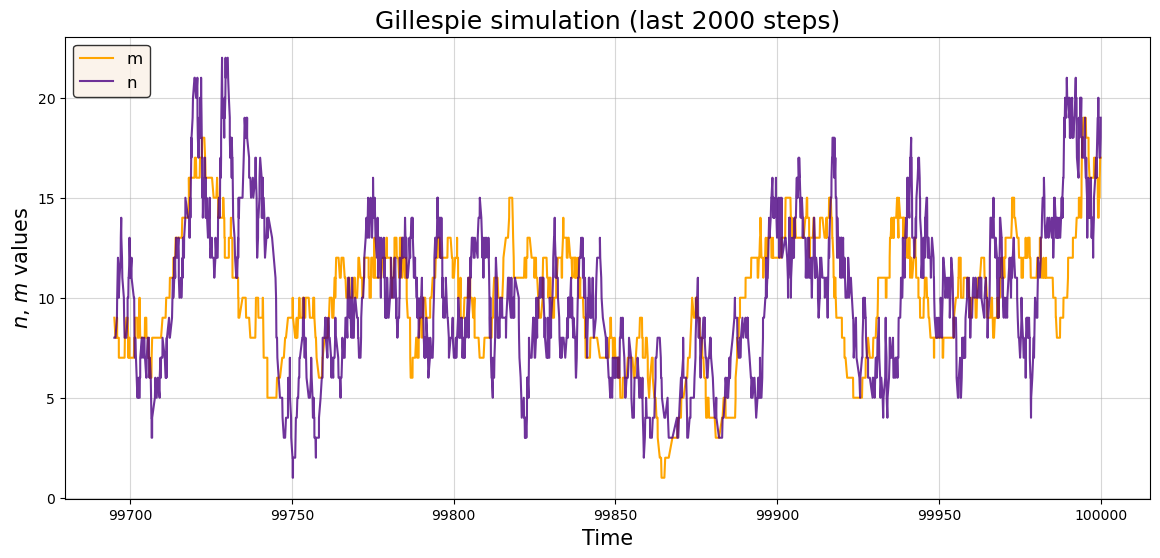

In [36]:
fig, ax = plt.subplots(1, 1, figsize=(14, 6))

ax.plot(t_evolve[-2000:], m_evolve[-2000:], label="m", linewidth=1.5, color = 'orange')
ax.plot(t_evolve[-2000:], n_evolve[-2000:], label="n", linewidth = 1.5, color = 'indigo', alpha=0.8)
ax.grid(alpha = 0.5)
ax.set_xlabel('Time', fontsize = 15)
ax.set_ylabel('$n$, $m$ values', fontsize = 15)
ax.set_title('Gillespie simulation (last 2000 steps)', fontsize = 18)
ax.legend(edgecolor='black', facecolor='linen', fontsize=12, loc ='best')
plt.show()

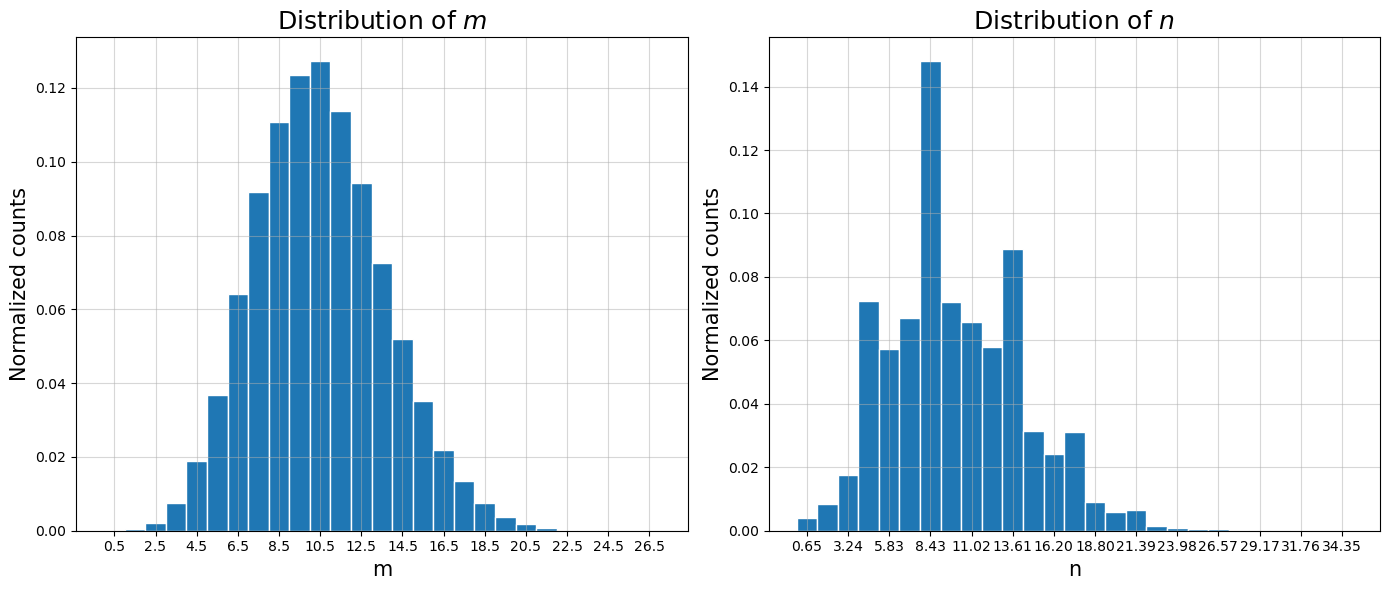

In [40]:
dt_list = np.array(t_evolve[1:])-np.array(t_evolve[:-1])

fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(14, 6))
_, bins, _ = ax0.hist(m_evolve[:-1], weights=dt_list, bins=27, edgecolor = 'white', color='C0', density=True)
ax0.grid(alpha=0.5)
ax0.set_xlabel('m', fontsize = 15)
ax0.set_ylabel('Normalized counts', fontsize = 15)
ax0.set_title('Distribution of $m$', fontsize = 18)

bins_plot = np.round(((bins[1:]+bins[:-1])/2)[::2], 2)
ax0.set_xticks(bins_plot)

_, bins, _ = ax1.hist(n_evolve[:-1], weights=dt_list, bins=27, edgecolor = 'white', color='C0', density=True)
ax1.grid(alpha=0.5)
ax1.set_xlabel('n', fontsize = 15)
ax1.set_ylabel('Normalized counts', fontsize = 15)
ax1.set_title('Distribution of $n$', fontsize = 18)

bins_plot = np.round(((bins[1:]+bins[:-1])/2)[::2], 2)
ax1.set_xticks(bins_plot)

plt.tight_layout()
plt.show()


# References 
**[Gillepsie07]** <br>
Gillespie DT. _Stochastic simulation of chemical kinetics_. Annu Rev Phys Chem. 2007;58:35-55. doi: 10.1146/annurev.physchem.58.032806.104637. 
